<a href="https://colab.research.google.com/github/Gaussiandra/NTA_Landmarks_Detection/blob/master/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jun 10 18:20:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Импорт библиотек

In [2]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-mbwfx13j
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-mbwfx13j
     |████████████████████████████████| 634kB 2.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=a122450686b106010395b0cfe39852bbe6e6e42b2b48f995d270458e09fec743
  Stored in directory: /tmp/pip-ephem-wheel-cache-8b7znif1/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=04b5751f294c3cacf25f9737a6c0bab5a6854ace4628216c0aa734f46100cf53
  Stored in directory: /tmp/pip-ephem-wheel-cache-8b7znif1/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

In [0]:
import os
import sys
import cv2
import gc
import time
import random
import pickle
import albumentations as albu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import transforms
from torch.nn import functional as fnn
from torchvision import transforms

In [4]:
!git clone https://github.com/HRNet/HRNet-Facial-Landmark-Detection.git
sys.path.append(os.path.abspath(os.path.join('HRNet-Facial-Landmark-Detection', 'lib')))

Cloning into 'HRNet-Facial-Landmark-Detection'...
remote: Enumerating objects: 183, done.
remote: Total 183 (delta 0), reused 0 (delta 0), pack-reused 183
Receiving objects: 100% (183/183), 3.59 MiB | 2.78 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [0]:
import models
import yaml
yaml_obj = yaml.safe_load(open('/content/HRNet-Facial-Landmark-Detection/experiments/300w/face_alignment_300w_hrnet_w18.yaml', 'r'))

In [0]:
# https://stackoverflow.com/a/23689767/12495874
class DotDict(dict):
    def __getattr__(*args):
        val = dict.get(*args) 
        return DotDict(val) if type(val) is dict else val
        
yaml_obj = DotDict(yaml_obj)

In [0]:
back_bone = models.get_face_alignment_net(yaml_obj)
back_bone.head[3] = nn.Conv2d(270, 2*NUM_PTS, (1, 1))

In [0]:
model = nn.Sequential(
    back_bone,
    nn.BatchNorm2d(2*NUM_PTS),
    nn.ReLU(inplace=True),
    nn.Conv2d(2*NUM_PTS, 2*NUM_PTS, kernel_size=(2, 2), stride=(2, 2)),

    nn.BatchNorm2d(2*NUM_PTS),
    nn.ReLU(inplace=True),
    nn.Conv2d(2*NUM_PTS, 2*NUM_PTS, kernel_size=(2, 2), stride=(2, 2)),

    nn.BatchNorm2d(2*NUM_PTS),
    nn.ReLU(inplace=True),
    nn.Conv2d(2*NUM_PTS, 2*NUM_PTS, kernel_size=(2, 2), stride=(2, 2)),

    nn.BatchNorm2d(2*NUM_PTS),
    nn.ReLU(inplace=True),
    nn.Conv2d(2*NUM_PTS, 2*NUM_PTS, kernel_size=(5, 5)),

    nn.Flatten()
).to(device)

In [164]:
model(torch.randn(4, 3, 160, 160).to(device)).shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([4, 388])

## Параметры

In [0]:
NUM_PTS = 194
CROP_SIZE = 160
BATCH_SIZE = 64

In [0]:
SEED = 3462

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
from google.colab import drive
drive.mount('/content/drive')

global_path = '/content/drive/My Drive/ML/NTA Landmarks Detection/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
TEST_PATH = global_path+"data/baseline_NTA/data/test/" 
TRAIN_PATH = global_path+"data/baseline_NTA/data/train/"
SUBMISSION_PATH = global_path+"data/baseline_NTA/data/train/"
LANDMARKS = global_path+"data/baseline_NTA/data/train/landmarks.csv"

SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"

In [16]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.max_memory_allocated(device='cuda'))
print(torch.cuda.empty_cache())

1.5.0+cu101
10.1
7603
True
1
62094848
None


In [0]:
ignored_train_names = set({
    '110520830_5.jpg',
    '160565613_2.jpg',
    '171198578_1.jpg',
    '2071191303_1.jpg',
    '2076592686_3.jpg',
    '2202089258_1.jpg',
    '2106937488_1.jpg',
    '131787989_1.jpg',
    '11564757_1.jpg',
    '214426541_2.jpg',
    '2054916149_1.jpg',
    '2204494382_1.jpg',
    '2065218949_1.jpg',
    '171907511_1.jpg',
    '240281904_1.jpg',
    '2065219235_1.jpg',
    '2398691129_1.jpg',
    '2233737284_1.jpg',
    '2546411220_1.jpg',
    '2152239275_2.jpg',
    '2306258846_1.jpg',
    '2620035751_8.jpg',
    '173744986_2.jpg',
    '1269874180_1.jpg',
    '2152239275_1.jpg',
    '2219165887_1.jpg',
    '2533908657_2.jpg',
    '218904413_1.jpg',
    '2344972348_1.jpg',
    '2477515529_1.jpg',
    '2356460241_1.jpg',
    '2433671054_1.jpg',
    '218904413_2.jpg',
    '2857823310_2.jpg',
    '1657180938_2.jpg',
    '2304061735_1.jpg',
    '2076592686_1.jpg',
    '1657179414_1.jpg',
    '26041966_2.jpg',
    '2822983493_3.jpg',
    '2140620254_2.jpg',
    '2165528796_1.jpg',
})

In [0]:
class LandmarksDataset(Dataset):
    def __init__(self, root, init_augmentations, split, train_augm=None, test_augm=None):
        assert split in ('train', 'test')

        super(LandmarksDataset, self).__init__()
        self.root = root
        self.init_augmentations = init_augmentations
        self.split = split
        self.train_augm = train_augm
        self.test_augm = test_augm

        file_name = os.path.join(root, 'test_points.csv' if split == "test" else 'landmarks.csv')
        images_root = os.path.join(root, "images")

        self.samples = []
        self.name_to_idx = {}

        with open(file_name, "rt") as fp:
            for i, line in tqdm(enumerate(fp), total=len(os.listdir(images_root))):
                if i == 0:
                    continue  # skip header

                elements = line.strip().split(",")
                image_name = os.path.join(images_root, elements[0])
                cur_img = cv2.imread(image_name)
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

                if split == "train":
                    landmarks = list(map(np.int16, elements[1:]))
                    landmarks = np.array(landmarks, dtype=np.int16).reshape((len(landmarks) // 2, 2))
                else:
                    landmarks = []

                augmented_data = init_augmentations(image=cur_img, keypoints=landmarks)
                cur_sample = {
                    'x_init_resolution': cur_img.shape[1],
                    'y_init_resolution': cur_img.shape[0],
                    'image': augmented_data['image'],
                    'keypoints': augmented_data['keypoints'],
                    'img_name': elements[0]
                }

                self.name_to_idx[cur_sample['img_name']] = i - 1
                self.samples.append(cur_sample)

    def get_box(self, keypoints):
        keypoints_copy = np.array(keypoints)
        bound_size = np.random.randint(15, 40)

        x_min, y_min = keypoints_copy.min(axis=0).round().astype(np.int)
        x_max, y_max = keypoints_copy.max(axis=0).round().astype(np.int)
        
        return (
            max(0, x_min - bound_size),
            max(0, y_min - bound_size),
            min(2*CROP_SIZE, x_max + bound_size),
            min(2*CROP_SIZE, y_max + bound_size)
        )
    
    def __getitem__(self, idx):
        if isinstance(idx, str):
            idx = self.name_to_idx[idx]

        cur_sample = dict(self.samples[idx])

        if self.split == 'train':
            if cur_sample['img_name'] in ignored_train_names:
                cur_sample = dict(np.random.choice(self.samples))

            augmented_data = self.train_augm(
                cropping_bbox=self.get_box(cur_sample['keypoints']),
                **cur_sample
            )
            
            cur_sample['image'] = augmented_data['image']
            cur_sample['keypoints'] = np.array(augmented_data['keypoints'])
            return cur_sample
        else:
            return self.test_augm(**cur_sample)

    def __len__(self):
        return len(self.samples)

In [0]:
# Корректный флип точек нагло скопирован из ods
# https://opendatascience.slack.com/archives/CGHGA0DQC/p1591103022218100?thread_ts=1591101465.217800&cid=CGHGA0DQC

keypoint_reflection_indexes = [
    [slice(0, 21), slice(40, 19, -1)],
    [slice(41, 50), slice(57, 48, -1)],
    [slice(58, 65), slice(71, 64, -1)],
    [slice(72, 79), slice(85, 78, -1)],
    [slice(86, 93), slice(99, 92, -1)],
    [slice(100, 107), slice(113, 106, -1)],
    [slice(114, 134), slice(134, 154)],
    [slice(154, 174), slice(174, 194)]
]

def reflect_keypoints(keypoints):
    new_keypoints = deepcopy(keypoints)
    for slice1, slice2 in keypoint_reflection_indexes:
        new_keypoints[slice1] = keypoints[slice2]
        new_keypoints[slice2] = keypoints[slice1]
    return new_keypoints

class CustomHorizontalFlip(albu.HorizontalFlip):
    def apply_to_keypoints(self, keypoints, **params):
        keypoints = reflect_keypoints(keypoints)
        return super().apply_to_keypoints(keypoints, **params)

class CustomCoarseDropout(albu.CoarseDropout):
    def apply(self, image, fill_value=0, holes=(), **params):
        return albu.augmentations.functional.cutout(image, holes, image.mean())

init_augm = albu.Compose([
    albu.LongestMaxSize(2*CROP_SIZE),
    albu.PadIfNeeded(2*CROP_SIZE, 2*CROP_SIZE, cv2.BORDER_CONSTANT, value=0),                  
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

train_augm = albu.Compose([
    albu.RandomCropNearBBox(0.07, p=0.5),
    albu.IAAPerspective((0.07, 0.07), p=0.1),###
    albu.Rotate(15, p=0.5),######
    albu.Resize(CROP_SIZE, CROP_SIZE),
    CustomHorizontalFlip(p=0.5),

    albu.RGBShift(0.02, 0.02, 0.02, p=0.5),
    albu.HueSaturationValue(10, 20, 10, p=0.5),
    albu.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    albu.CLAHE(2, p=0.5),
    albu.IAAEmboss(p=0.5),
    albu.MedianBlur(4, p=0.5),
    albu.ToGray(p=0.15),
    albu.IAASharpen(p=0.5),
    albu.ISONoise(p=0.5),
    albu.ImageCompression(90, p=0.33),
    #CustomCoarseDropout(120, 6, 6, min_holes=40, p=0.5), ##

    albu.Normalize()
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

test_augm = albu.Compose([
    albu.Resize(CROP_SIZE, CROP_SIZE),
    albu.Normalize()
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

#submit_augm = albu.Compose([
#    albu.Resize(CROP_SIZE, CROP_SIZE),
#    albu.Normalize()
#], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

In [0]:
def augment_test(images):
    

    with torch.no_grad():
        pred_landmarks = model(images).cpu().numpy()

In [0]:
##whole_dataset = LandmarksDataset(os.path.join(TRAIN_PATH), init_augm, "train", train_augm=train_augm)
#test_dataset = LandmarksDataset(os.path.join(TEST_PATH), init_augm, "test", test_augm=test_augm)
#pickle.dump(whole_dataset, open(global_path+'whole_ds.pkl', 'wb'))
#pickle.dump(test_dataset, open(global_path+'test_ds.pkl', 'wb'))

In [0]:
whole_dataset = pickle.load(open(global_path+'whole_ds.pkl', 'rb'))
test_dataset = pickle.load(open(global_path+'test_ds.pkl', 'rb'))

In [0]:
whole_dataset.train_augm = train_augm
test_dataset.test_augm = test_augm

In [0]:
def vis_points(image, points, diameter=15):
    im = image.copy()
    
    for i, (x, y) in enumerate(points):
        cv2.circle(im, (int(x), int(y)), diameter, (255, 0, 0), -1)

    plt.figure(figsize=(6, 6))
    plt.imshow(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

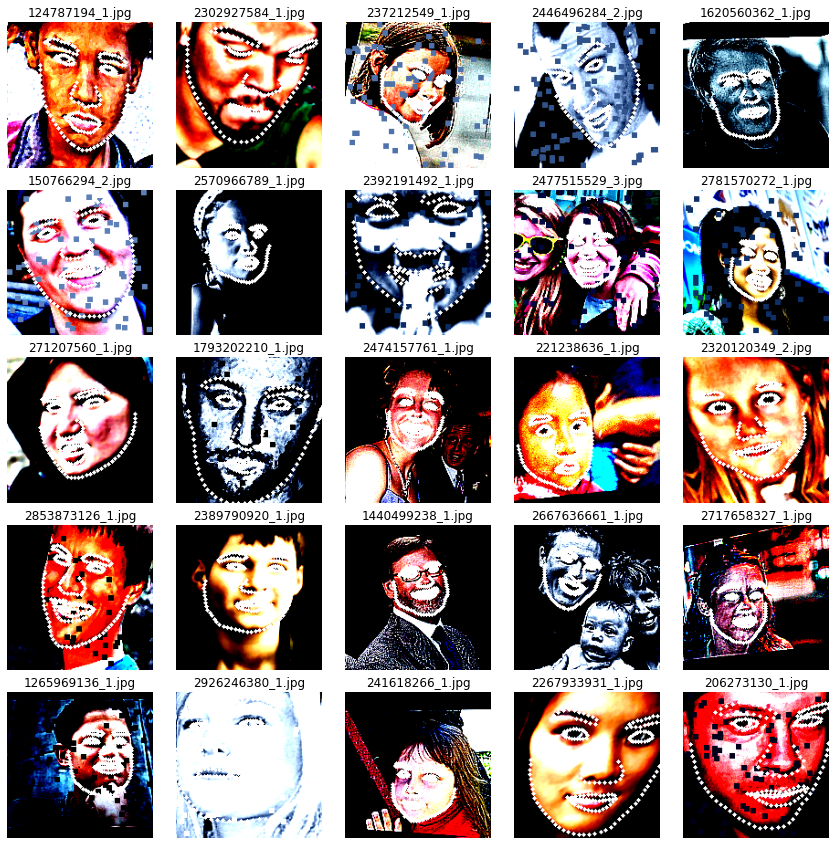

In [0]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.05, hspace=0.15)

for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.axis('off')

    augm_img = whole_dataset[np.random.randint(0, 2001)]
    im = augm_img['image'].copy()  

    for x, y in augm_img['keypoints']:
        cv2.circle(im, (int(x), int(y)), 2, (255, 255, 255), -1)

    plt.title(augm_img['img_name'])
    plt.imshow(im)

In [0]:
torch.manual_seed(SEED)

from torch.utils.data import random_split
train_size = int(0.9 * len(whole_dataset))
val_size = len(whole_dataset) - train_size
train_dataset, val_dataset = random_split(whole_dataset, [train_size, val_size])

In [0]:
#######
train_iter = DataLoader(whole_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
val_iter = DataLoader(whole_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

In [33]:
!pip install facenet_pytorch

In [0]:
from facenet_pytorch import InceptionResnetV1
vggface2 = InceptionResnetV1(pretrained='vggface2')

In [0]:
back_bone = nn.Sequential(*list(vggface2.children())[:-5])
#for param in back_bone[:-2].parameters(): 
#    param.requires_grad = False

In [0]:
model = nn.Sequential(
    back_bone,
    nn.LeakyReLU(),

    nn.Conv2d(1792, 448, (3, 3), 1, 1),
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(),
    nn.Dropout(0.05),

    nn.Linear(448, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.05),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.05),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
    nn.LeakyReLU(),
    nn.Dropout(0.05),

    nn.Linear(2*NUM_PTS, 2*NUM_PTS),
).to(device)


In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
loss_fn = fnn.mse_loss

cur_iter = 0

In [0]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, verbose=True)

In [28]:
sum(p.numel() for p in model.parameters() if p.requires_grad), sum(p.numel() for p in model.parameters())

(15315902, 15315902)

In [0]:
model

Sequential(
  (0): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  

In [0]:
# Другой facenet
#+ freeze layers
# catboost поверх -- та статья с ансамблями на архиве
# Работа с фото с самыми высокими ошибками, hard negatives mining?
#+ написать проверку при субмите - Клиппинг предсказанны координат
#+ Усреднять значения для теста на аугментации
#+ Усреднять веса с лучших точек
# погуглить про pseudolabeling
#+ reduce LR on plateau + early stopping
#+ Отключать/уменьшать аугментации в конце
#+ Hardneg по оригиналам, а не по аугментированным картинкам
# аугментации на ганах - stargan
# HRNet для лиц
#https://towardsdatascience.com/a-glance-into-competitive-data-science-the-best-practices-for-computer-vision-2c77c5d98d19
#bagging
#mixup
#cutmix
#kornia
#hybrid mask cascade mask r-cnn
#погуглить про RL/randaugment для подбора аугментаций
#аугментации из видео кузина
# https://towardsdatascience.com/pseudo-labeling-to-deal-with-small-datasets-what-why-how-fd6f903213af
#Выход на свертке лол
#Опыт hnm
#https://arxiv.org/pdf/2002.00537.pdf
#https://arxiv.org/pdf/1911.04252.pdf
#https://arxiv.org/pdf/1908.07919.pdf
#https://m.habr.com/ru/company/ods/blog/413667/
#https://habr.com/ru/post/332534/
#https://youtu.be/kTHemZ9aQFo

In [0]:
#!rm -rf '/content/drive/My Drive/ML/TG_DL/10/tensorboard/'

In [0]:
model_name = 'hrnet conv + 4conv bb grad_'

In [69]:
last_checkpoint = torch.load(
    global_path+'hrnet conv + 4conv bb grad__8615_4.202302955091_full ds.tar',
    map_location=device
)

model.load_state_dict(last_checkpoint['model'])
optimizer.load_state_dict(last_checkpoint['optim'])
scheduler.load_state_dict(last_checkpoint['scheduler'])
cur_iter = last_checkpoint['n_iters']

cur_iter, last_checkpoint['n_iters']

(8615, 8615)

In [0]:
import tensorflow as tf
%load_ext tensorboard

In [0]:
tb_path = global_path+'tensorboard/'
train_summary_writer = tf.summary.create_file_writer(tb_path+model_name+'_train')
val_summary_writer = tf.summary.create_file_writer(tb_path+model_name+'_val')

In [64]:
%tensorboard --logdir '/content/drive/My Drive/ML/NTA Landmarks Detection/tensorboard/'

<IPython.core.display.Javascript object>

In [0]:
def unpack_batch(batch):
    images = batch['image'].permute([0, 3, 1, 2]).to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
    landmarks = batch['keypoints'].reshape(-1, 2 * NUM_PTS).to(torch.float32).to(device)  # B x (2 * NUM_PTS)

    return images, landmarks

In [0]:
min_loss = 4.3

In [66]:
# Избавиться от дублирования кода
MINE_HARD_NEGATIVES = False

for e in range(100):
    hard_losses = torch.tensor([], device=device)
    hard_names = np.array([])

    for batch in tqdm(train_iter, desc=str(f'{e}_{cur_iter}')):
        model.train()
        optimizer.zero_grad()
        whole_dataset.train_augm = train_augm

        images, landmarks = unpack_batch(batch)
        pred_landmarks = model(images)
        loss = loss_fn(pred_landmarks, landmarks, reduction='none')

        loss.mean().backward()
        optimizer.step()

        if MINE_HARD_NEGATIVES:
            hard_indecies = loss.mean(dim=1).argsort(descending=True)[:2]
            hard_losses = torch.cat([hard_losses, loss[hard_indecies].mean(dim=1)])
            hard_names = np.hstack((hard_names, np.array(batch['img_name'])[hard_indecies.cpu()]))
        
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss.mean().item(), step=cur_iter)

        cur_iter += 1
    
    if MINE_HARD_NEGATIVES:
        model.train()
        optimizer.zero_grad()
        whole_dataset.train_augm = train_augm

        batch = next(iter(DataLoader(
            whole_dataset,
            batch_size=BATCH_SIZE, 
            sampler=SubsetRandomSampler(hard_names),
            pin_memory=True
        )))

        images, landmarks = unpack_batch(batch)

        loss = loss_fn(model(images), landmarks)
        loss.backward()
        optimizer.step()

        with train_summary_writer.as_default():
            tf.summary.scalar('loss', loss.item(), step=cur_iter+1)
        cur_iter += 1
    
    test_losses = []
    for batch in val_iter:
        model.eval()
        whole_dataset.train_augm = test_augm

        images, landmarks = unpack_batch(batch)

        with torch.no_grad():
            pred_landmarks = model(images)
        test_losses.append(loss_fn(pred_landmarks, landmarks).item())

    test_loss = np.mean(test_losses)
    print(cur_iter, test_loss)
    scheduler.step(test_loss)

    with val_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss, step=cur_iter)

    if test_loss < min_loss:
        min_loss = test_loss

        save_path = f'{global_path}{model_name}_{cur_iter}_{min_loss}_full ds.tar'
        assert not os.path.exists(save_path)
        torch.save({
                    'model': model.state_dict(),
                    'optim': optimizer.state_dict(),
                    'n_iters': cur_iter,
                    'scheduler': scheduler.state_dict(),
                    'min_loss': min_loss
                }, save_path)      

        print(save_path)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



8583 4.293639175593853
/content/drive/My Drive/ML/NTA Landmarks Detection/hrnet conv + 4conv bb grad__8583_4.293639175593853_full ds.tar



8615 4.202302955091
/content/drive/My Drive/ML/NTA Landmarks Detection/hrnet conv + 4conv bb grad__8615_4.202302955091_full ds.tar



8647 4.240586943924427



8679 4.23284674435854


KeyboardInterrupt: ignored

In [47]:
save_path = f'{global_path}{model_name}_{cur_iter}_{min_loss}_full ds.tar'
assert not os.path.exists(save_path)
torch.save({
            'model': model.state_dict(),
            'optim': optimizer.state_dict(),
            'n_iters': cur_iter,
            'scheduler': scheduler.state_dict(),
            'min_loss': min_loss
        }, save_path)      

print(save_path)

/content/drive/My Drive/ML/NTA Landmarks Detection/hrnet conv + 4conv bb grad__7285_4.1_full ds.tar


In [0]:
set_of_clowns = hard_names
landmark_csv = pd.read_csv(os.path.join(TRAIN_PATH, 'landmarks.csv'), index_col='filename')

chf = albu.Compose([
    albu.NoOp()
], keypoint_params=albu.KeypointParams(format='xy', remove_invisible=False))

images_root = os.path.join(TRAIN_PATH, "images")

for image_name in set_of_clowns:
    print(image_name)

    cur_img = cv2.imread(os.path.join(images_root, image_name))
    cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

    landmarks = list(map(np.int16, landmark_csv.loc[image_name].values))
    landmarks = np.array(landmarks, dtype=np.int16).reshape((len(landmarks) // 2, 2))

    augm_img = chf(image=cur_img, keypoints=landmarks)
    vis_points(augm_img['image'], augm_img['keypoints'], diameter=4)
    plt.show()

In [71]:
losses = []
whole_dataset.train_augm = test_augm
######
val_iter = DataLoader(whole_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
model.eval()

for batch in val_iter:
    images = batch['image'].permute([0, 3, 1, 2]).to(device)
    landmarks = batch['keypoints'].reshape(-1, 2 * NUM_PTS).to(torch.float32).to(device)

    with torch.no_grad():
        pred_landmarks = model(images)
    loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
    losses.append(loss.item())
    
np.mean(losses), np.std(losses)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(4.101667419075966, 0.6109800881849606)

In [0]:
def shift_augm_landmark(init_resolution, landmarks):
    points = torch.tensor(landmarks) 

    scale_factor = max(init_resolution) / CROP_SIZE
    x_margin = (CROP_SIZE - init_resolution[0] / scale_factor) / 2
    y_margin = (CROP_SIZE - init_resolution[1] / scale_factor) / 2
    margin_pair = np.array([x_margin, y_margin])

    handle_pair = lambda x: (x - margin_pair) * scale_factor
    return list(map(handle_pair, points))
    
def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    
    cur_str = 0
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch['image'].permute([0, 3, 1, 2]).to(device) 

        with torch.no_grad():
            pred_landmarks = model(images).cpu().numpy()  # B x NUM_PTS x 2

        for j in range(len(batch['x_init_resolution'])):
            hz = shift_augm_landmark((batch['x_init_resolution'][j], batch['y_init_resolution'][j]), pred_landmarks[j].reshape(NUM_PTS, 2))
            hz = np.array(list(map(lambda x: np.array(x), hz)))

            predictions[cur_str] = hz
            cur_str += 1

    return predictions

def create_submission(path_to_data, test_predictions, path_to_submission_file):
    test_dir = os.path.join(path_to_data)

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter=',')
    
    for i, row in mapping.iterrows():   
        file_name = row[0]

        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')

In [73]:
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
test_predictions = predict(model, test_iter, device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [0]:
create_submission(TEST_PATH, test_predictions, "submit.csv")

---

In [0]:
def get_orig_img(path, split, index):
    root = path
    file_name = os.path.join(root, 'test_points.csv' if split == "test" else 'landmarks.csv')
    images_root = os.path.join(root, "images")

    with open(file_name, "rt") as fp:
        for i, line in tqdm(enumerate(fp)):
            if i != index+1:
                continue

            elements = line.strip().split(",")
            image_name = os.path.join(images_root, elements[0])
            cur_img = cv2.imread(image_name)
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)

            return cur_img

def coords_from_sumb_file(path, index):
    with open(path, "rt") as fp:
        for i, line in tqdm(enumerate(fp)):
            if i != index+1:
                continue

            elements = line.strip().split(",")
            return np.array(list(map(int, elements[1:])))
            
def landmarks2pairs(points):
    x_coords = np.array(points[::2], dtype=np.uint8)
    y_coords = np.array(points[1::2], dtype=np.uint8)

    return list(zip(x_coords, y_coords))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


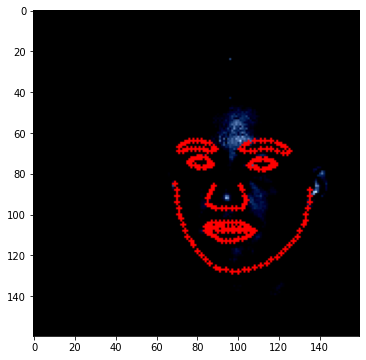

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


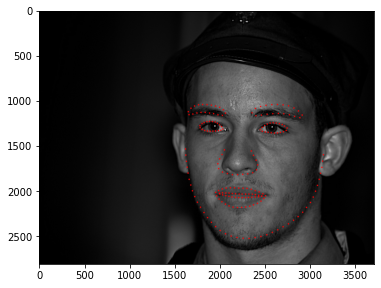

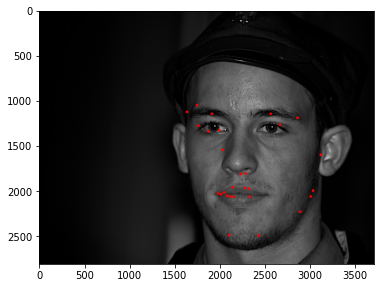

In [81]:
cur_img, cur_predictions, id = 0, 0, np.random.randint(64)

model.eval()
test_iter = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)
for i, data in enumerate(test_iter):
    cur_img = data['image'].permute([0, 3, 1, 2])[id].unsqueeze(dim=0).to(device)
    cur_predictions = model(cur_img).cpu().detach()
    break

vis_points(test_dataset[id]['image'], landmarks2pairs(cur_predictions[0]), diameter=1)
plt.show()

cur_orig_img = get_orig_img(TEST_PATH, 'test', id)
shifted_preds = shift_augm_landmark((test_dataset[id]['x_init_resolution'], test_dataset[id]['y_init_resolution']), cur_predictions[0].reshape(194, 2))
vis_points(cur_orig_img, shifted_preds, 8)
plt.show()

vis_points(cur_orig_img, coords_from_sumb_file("submit.csv", id).reshape(-1, 2))

---